<a href="https://colab.research.google.com/github/taufiqyfirdaus/Machine_Learning/blob/main/modul10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama  : Taufiqy Firdaus Jatu

NIM   : 2141720124

Kelas : TI-3G

---
## **Praktikum 1**


**1. Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history['val_'+metric], '')
 plt.plot(history.history[metric])
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

**2. Setup input pipeline**


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Remember the chain-smoking channeler exposed on 60 Minutes a few years ago? This is her. Lots of folks reviewed this movie without checking the bona fides of the filmmakers. The producers have been using phony "word of mouth" promotions very successfully without disclosing the financial and philosophical underpinnings for this piece of marketing tripe. If you believe in channeling, reincarnation, new age dreck and day-old baloney, this film is for you. If you want a discussion of quantum physics or reality, look elsewhere. The purpose of this movie is to convince you that Ramtha isn\'t a wacko, so you\'ll give her a bunch of your money. If you can tiptoe through the Ramtha website without howling in disbelief, then maybe you\'ll think the bucks you dropped on this infomercial for insanity was well spent. <http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>'
 b'I saw this "hot" movie when it came out in 1986. It had a X rating for a brief scene involving 

**3. Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[364,   2,   1, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0],
       [ 10, 316, 175, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Remember the chain-smoking channeler exposed on 60 Minutes a few years ago? This is her. Lots of folks reviewed this movie without checking the bona fides of the filmmakers. The producers have been using phony "word of mouth" promotions very successfully without disclosing the financial and philosophical underpinnings for this piece of marketing tripe. If you believe in channeling, reincarnation, new age dreck and day-old baloney, this film is for you. If you want a discussion of quantum physics or reality, look elsewhere. The purpose of this movie is to convince you that Ramtha isn\'t a wacko, so you\'ll give her a bunch of your money. If you can tiptoe through the Ramtha website without howling in disbelief, then maybe you\'ll think the bucks you dropped on this infomercial for insanity was well spent. <http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>'
Round-trip:  remember the [UNK] [UNK] [UNK] on [UNK] minutes a few years ago this is her lots of

**4. Buat Model**


In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00103054]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 79ms/step
[-0.00103055]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**5. Train Model**

In [15]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 52s 105ms/step - loss: 0.6571 - accuracy: 0.5519 - val_loss: 0.5438 - val_accuracy: 0.7208
Epoch 2/10
391/391 [==============================] - 27s 70ms/step - loss: 0.4897 - accuracy: 0.7482 - val_loss: 0.4312 - val_accuracy: 0.8073
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4000 - accuracy: 0.8212 - val_loss: 0.4066 - val_accuracy: 0.7865
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3608 - accuracy: 0.8430 - val_loss: 0.3734 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3373 - accuracy: 0.8562 - val_loss: 0.3417 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3220 - accuracy: 0.8628 - val_loss: 0.3334 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3173 - accuracy: 0.8659 - val_loss: 0.3387 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 10s 26ms/step - loss: 0.3263 - accuracy: 0.8643
Test Loss: 0.3262941539287567
Test Accuracy: 0.8643199801445007


(0.0, 0.6516511455178261)

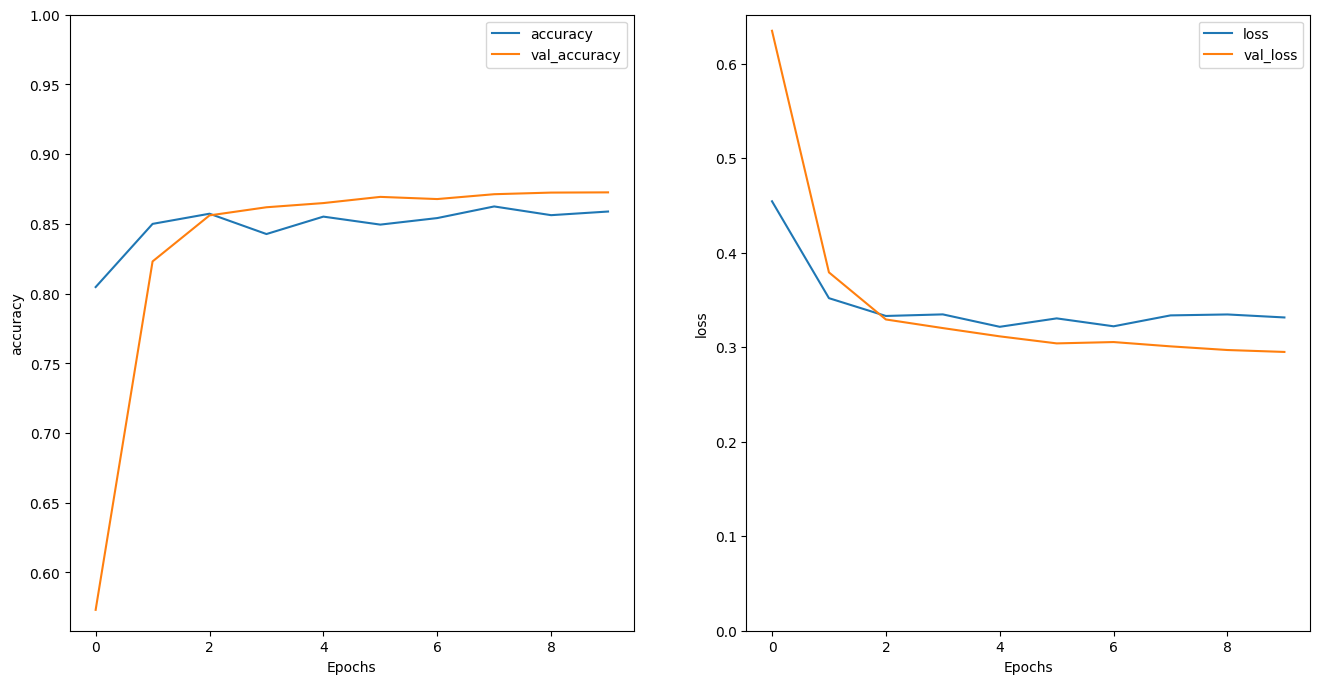

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Assuming 'model' is properly defined and compiled
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


**6. Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)


Epoch 1/10
391/391 [==============================] - 86s 176ms/step - loss: 0.6260 - accuracy: 0.5910 - val_loss: 0.4447 - val_accuracy: 0.8026
Epoch 2/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3945 - accuracy: 0.8298 - val_loss: 0.3606 - val_accuracy: 0.8562
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3436 - accuracy: 0.8548 - val_loss: 0.3470 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3241 - accuracy: 0.8639 - val_loss: 0.3363 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3149 - accuracy: 0.8675 - val_loss: 0.3219 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3099 - accuracy: 0.8699 - val_loss: 0.3177 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3061 - accuracy: 0.8702 - val_loss: 0.3230 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 45ms/step - loss: 0.3201 - accuracy: 0.8614
Test Loss: 0.32012394070625305
Test Accuracy: 0.8613600134849548


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.1094615]]


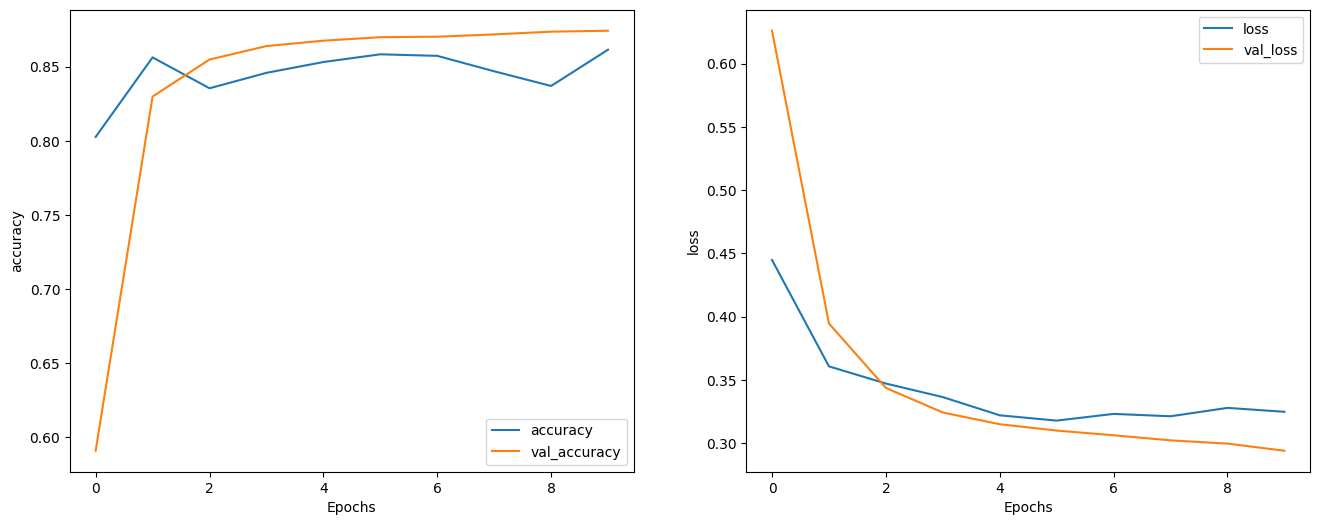

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

---
## **Praktikum 2**



**1. Setup**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

**2. Download Dataset Shakespeare**


In [ ]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt',
                                     'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


**3. Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**4. Olah Teks**


In [ ]:
example_texts=['abcdefg',
               'xyz']
chars=tf.strings.unicode_split(example_texts,
                               input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [ ]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**5. Prediksi**

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?




**6. Membuat Trianing Set dan Target**

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian `seq_length+1`. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**7. Membuat Batch Training**



In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**8. Buat Model**



In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**9. Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([37, 14,  3, 25,  4, 45, 10, 20,  5, 27, 20, 23, 56, 23, 35, 51, 56,
       29, 12, 61, 18, 19, 14, 17, 42, 48, 62, 48, 15, 39, 57,  3, 18, 19,
       51, 58, 53, 54,  7, 50, 55, 39, 26, 60, 44,  1, 16, 23, 49,  0, 15,
       56,  7, 52, 11, 37,  5, 49, 12, 48, 48, 22, 17, 12, 56, 37, 24, 64,
       41, 59, 34,  9, 47, 14, 40, 10, 27, 32, 44, 49,  6,  5, 65, 44,  7,
       57, 13,  6, 37, 23, 20, 61, 11, 27, 35, 33, 57, 63, 28, 54])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b't to Ludlow.\nMadam, and you, my mother, will you go\nTo give your censures in this weighty business?\n'

Next Char Predictions:
 b"XA!L$f3G&NGJqJVlqP;vEFADciwiBZr!EFlsno,kpZMue\nCJj[UNK]Bq,m:X&j;iiID;qXKybtU.hAa3NSej'&ze,r?'XJGv:NVTrxOo"


**10. Train Model**

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.



**11. Tambahan optimizer dan fungsi loss**

loss function `tf.keras.losses.sparse_categorical_crossentropy` standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag `from_logits`.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1907105, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.06972

In [ ]:
model.compile(optimizer='adam', loss=loss)

**12. Konfigurasi Checkpoints**


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**13. Lakukan Proses Training**


In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 53ms/step - loss: 2.7320
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9931
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7142
Epoch 4/20
172/172 [==============================] - 11s 55ms/step - loss: 1.5529
Epoch 5/20
172/172 [==============================] - 12s 59ms/step - loss: 1.4530
Epoch 6/20
172/172 [==============================] - 12s 57ms/step - loss: 1.3852
Epoch 7/20
172/172 [==============================] - 11s 58ms/step - loss: 1.3321
Epoch 8/20
172/172 [==============================] - 12s 59ms/step - loss: 1.2878
Epoch 9/20
172/172 [==============================] - 11s 58ms/step - loss: 1.2465
Epoch 10/20
172/172 [==============================] - 11s 57ms/step - loss: 1.2080
Epoch 11/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1681
Epoch 12/20
172/172 [==============================] - 14s 61ms/step - loss: 1.1273
E

**14. Generate Teks**



In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Why, they hither be admited by the good
Loines on thee, tastals, oursaffers, witness shall
The sun upon your fretting gull'ds,
Betwixt the Travel and his knaves.
Three then, and he that blows with grief is
on the dish of ganner light. We must be here alone:
I never saw a few or none with our proof?

RATCLIFF:
Dispatch, Edward! further thou canst give?

KING RICHARD II:
Thou astimedies, take the king's dearer ape.
Where is my lady's lump-how doth; the poor duke's
counterfeit scandal; to search a quiet as twenty-tive; to report
In hands, say indeed, command. I had rather thank thee,
For thou shalt not naked, that fills at honest for me:
But, like a warring seas; I will not dine untiver.
Mercyful will be mother, beshow mine arm
Coriolanus, what with the gravelies
That will not have it so, and in good mind to my sweet lords,
Will you begin with you, when you shall ha', look to your knavery.

BAPTISTA:
Why do? I see But in our pleasure here
I cannot so: or cate in the other
sea-calei

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nO, sir, I tell thee your womb and favour. We have suidors him:\nTherefore, fellow, how he made your mainyaved.\nBut I have drawn so many of mine own.\n\nAUTOLYCUS:\n'Tis nothing spect.\nO most worthy and account myself a story\nMut-a little found; to-morrow thereby to his pack\nAs hither with your cretting cause to Salit.\n\nNORTHUMBERLAND:\nHow far be nowned from my sovereigns,\nAnd to deny him that I know of it; but thou wilt have\nThou could born much blush'd attempting them;\nAnd then let me bring my misdeeds, lawful kill\nCommand as best by yours from out affairs,\nStay not! then put in hell.\n\nHENRY BOLINGBROKE:\nI would follow it, I beseech you,\nWhere I find itself a man, how they had\nOur prayers attend us by the rich mistress.'\n\nTRANIO:\nAnd you are like to bed, and none can free\nFine the wild-Lord Look on me leave.\n\nRICHARD:\nGremio, 'twill so my child, with the\nbelliest jounness with the king? where, if Norfound, madam, both by each but a\nmistr

**15. Ekspor Model Generator**



In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
My queen?

GRUMIO:
Why look you so often?

WESTMORELAND:
MARI wrong him, I am resolved: the very nu


---
## **TUGAS**


Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.


Gunakan `tf.GradientTape` untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca `eager execution guide`.

Prosedurnya adalah "
1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan `train_step method` sesuai dengan  `Keras' train_step conventions`. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras `Model.compile` and `Model.fit methods`.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 60ms/step - loss: 2.7175


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1715
Epoch 1 Batch 50 Loss 2.0496
Epoch 1 Batch 100 Loss 1.9365
Epoch 1 Batch 150 Loss 1.8391

Epoch 1 Loss: 1.9909
Time taken for 1 epoch 14.06 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8494
Epoch 2 Batch 50 Loss 1.7712
Epoch 2 Batch 100 Loss 1.6242
Epoch 2 Batch 150 Loss 1.6245

Epoch 2 Loss: 1.7151
Time taken for 1 epoch 11.13 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6375
Epoch 3 Batch 50 Loss 1.5644
Epoch 3 Batch 100 Loss 1.5573
Epoch 3 Batch 150 Loss 1.5115

Epoch 3 Loss: 1.5533
Time taken for 1 epoch 11.47 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4421
Epoch 4 Batch 50 Loss 1.4348
Epoch 4 Batch 100 Loss 1.4589
Epoch 4 Batch 150 Loss 1.4441

Epoch 4 Loss: 1.4534
Time taken for 1 epoch 11.85 sec
_____________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

Terdapat beberapa perbedaan utama antara praktikum 2 dan pelatihan tugas yang jalankan:

1. **Model Architectures**:
   Praktikum 2 menggunakan model yang lebih sederhana yaitu RNN (Recurrent Neural Network), sementara pelatihan tugas menggunakan model yang lebih kompleks yaitu GRU (Gated Recurrent Unit).

2. **Epochs**:
   Praktikum 2, menjalankan model selama 20 epoch, sedangkan dalam pelatihan tugas, pelatihan model selama 10 epoch.

3. **Prosedur Pelatihan**:
   Praktikum 2 lebih sederhana dalam hal pelatihan dan menggunakan API model.fit() bawaan Keras sedangkan dalam pelatihan tugas,  mengimplementasikan loop pelatihan khusus dengan menggunakan train_step, yang memberikan lebih banyak kontrol atas proses pelatihan.

4. **Output Hasil Pelatihan**:
   Output dari praktikum 2 adalah informasi singkat tentang loss selama pelatihan sedangkan dalam pelatihan tugas, menghasilkan informasi yang lebih lengkap dengan mencantumkan loss untuk setiap batch dan untuk setiap epoch, serta waktu yang diperlukan untuk menjalankan setiap epoch.

5. **Waktu Eksekusi**:
   Praktikum 2 mungkin lebih cepat karena model sederhana dengan 20 epoch, sedangkan pelatihan tugas lebih lama karena 10 epoch dan menggunakan model yang lebih kompleks.
